In [1]:
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import tifffile
from torch.utils.data import Dataset, DataLoader
import torch
from pathlib import Path
import os
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from skimage import io, img_as_ubyte
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
import tifffile
import cv2
import plotly.figure_factory as ff

/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
num_classes = 2
class_names = ["0","1"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
input_shape = (224,224,3)

In [3]:
def val_classifier(val_loader, device,model,class_names):
    model.eval()
    all_preds = []
    all_preds2 = []
    all_labels = []
    for i, (batch_imgs, batch_labels) in enumerate(val_loader):
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        outputs = model(batch_imgs)
        probs = F.softmax(outputs, dim=1)[:,1]
        y_pred2 =  outputs.argmax(axis=1).detach().cpu().numpy()
        y_pred =  probs.detach().cpu().numpy()
        all_preds.extend(y_pred)
        all_preds2.extend(y_pred2)
        all_labels.extend(batch_labels.cpu().numpy())
    # Report
    print(confusion_matrix(all_labels, all_preds2))
    print(classification_report(all_labels, all_preds2))
    report = classification_report(all_labels, all_preds2, target_names=class_names, output_dict=True)
    print(report)
    return all_preds, all_labels, all_preds2

In [4]:
def load_pretrained_simclr_model(model_path):
    model = ResNetSimCLR(base_model= "resnet50",out_dim=2 )# .to(self.device)
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

In [5]:
class SimCLRClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(SimCLRClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(2048, 224), #old 2048, 512
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(224, num_classes)#512
        )

    def forward(self, x):
        features, _ = self.encoder(x)
        out = self.classifier(features)
        return out

In [6]:
class TIFDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: directory with subfolders per class, e.g.,
        root_dir/
            class1/
                img1.tif
                ...
            class2/
                img2.tif
                ...
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []

        #self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}
        dir_list = [x for x in os.listdir(root_dir) if x!='.DS_Store']
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(dir_list))}
        #print(self.class_to_idx)
        for cls_name, cls_idx in self.class_to_idx.items():
            cls_folder = self.root_dir / cls_name
            for img_path in cls_folder.glob("*.tif"):
                self.image_paths.append(img_path)
                self.labels.append(cls_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = tifffile.imread(path)

        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        if image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)  # Grayscale to RGB

        image = image.astype(np.float32)
        image /= image.max()

        image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


In [7]:
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, norm_layer=nn.InstanceNorm2d),
                            "resnet50": models.resnet50(pretrained=False)}

        resnet = self._get_basemodel(base_model)
        num_ftrs = resnet.fc.in_features

        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # projection MLP
        self.l1 = nn.Linear(num_ftrs, num_ftrs)
        self.l2 = nn.Linear(num_ftrs, out_dim)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
            print("Feature extractor:", model_name)
            return model
        except:
            raise ("Invalid model name. Check the config file and pass one of: resnet18 or resnet50")

    def forward(self, x):
        h = self.features(x)
        h = h.squeeze()

        x = self.l1(h)
        x = F.relu(x)
        x = self.l2(x)
        return h, x

## GSGT - T1

In [10]:
model_path  = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/CODES/runs/Jul29_11-10-57_DDLUFB08808/checkpoints/model.pth"

#model_path  = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/CODES/runs/Jul29_11-10-57_DDLUFB08808/checkpoints/model.pth"
simclr_model = load_pretrained_simclr_model(model_path)

Feature extractor: resnet50


/tmp/ipykernel_2906990/3537907158.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [9]:
finetune_model_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/CODES/Results/Resnet_bs8_ep50_sch10_lr1-4_wd_1-5_new_model/using_resnet1_model_train_val_new.pth"
finetune_model_path  = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/All_Sporadic/saved_models/2025-09-26 16-41-41/model.pth"

#finetune_model_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/CODES/Results/Resnet_bs8_ep60_sch10_lr1-4_wd_1-5/using_resnet1_model_train_val_new.pth"

## GSGT - T6

In [11]:
model_path  =  "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/GSGT_T6/runs/Sep03_11-21-10_kif-gh200-02.gladstone.internal/checkpoints/model.pth"
simclr_model = load_pretrained_simclr_model(model_path)
finetune_model_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/GSGT_T6/saved_models/2025-09-04 10-35-57.695107/using_resnet1_model_train_val_new.pth"


/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Feature extractor: resnet50


/tmp/ipykernel_2867396/3537907158.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


## All_C9ORF72

In [ ]:
simclr_model = load_pretrained_simclr_model(model_path)
finetune_model_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/All_C9ORF72/saved_models/2025-09-17 13-35-33/using_resnet1_model_train_val_new.pth"

/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



Feature extractor: resnet50


/tmp/ipykernel_2867396/3537907158.py:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



## ALL SPORADIC

In [12]:
model_path  =  "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/All_Sporadic/runs/Sep19_12-43-04_kif-gh200-03.gladstone.internal/checkpoints/model.pth"
simclr_model = load_pretrained_simclr_model(model_path)
finetune_model_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/All_Sporadic/saved_models/2025-09-26 16-41-41/model.pth"

Feature extractor: resnet50


/tmp/ipykernel_2906990/3537907158.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


In [13]:
model = SimCLRClassifier(simclr_model, num_classes=2)

In [14]:
state_dict = torch.load(finetune_model_path)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

/tmp/ipykernel_2906990/1682376191.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(finetune_model_path)


SimCLRClassifier(
  (encoder): ResNetSimCLR(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=T

In [15]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225]),
])

#test_dataset = TIFDataset("/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/test/", transform=data_transforms)
#test_dataset = TIFDataset("/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/All_C9ORF72/test/", transform=data_transforms)
test_dataset = TIFDataset("/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/All_Sporadic/test/", transform=data_transforms)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


all_preds, all_labels, all_preds2 = val_classifier(test_loader, device,model,class_names)


[[2055 1570]
 [1221 2404]]
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      3625
           1       0.60      0.66      0.63      3625

    accuracy                           0.62      7250
   macro avg       0.62      0.62      0.61      7250
weighted avg       0.62      0.62      0.61      7250

{'0': {'precision': 0.6272893772893773, 'recall': 0.5668965517241379, 'f1-score': 0.5955658600202869, 'support': 3625}, '1': {'precision': 0.6049320583794665, 'recall': 0.6631724137931034, 'f1-score': 0.6327148308988024, 'support': 3625}, 'accuracy': 0.6150344827586207, 'macro avg': {'precision': 0.6161107178344218, 'recall': 0.6150344827586207, 'f1-score': 0.6141403454595447, 'support': 7250}, 'weighted avg': {'precision': 0.616110717834422, 'recall': 0.6150344827586207, 'f1-score': 0.6141403454595448, 'support': 7250}}


In [17]:
output_dir = "/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/All_Sporadic/Results"

In [18]:
cm = confusion_matrix(all_labels, all_preds2)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                              display_labels=["Control lines","TDP-43"],
#                              )
#disp.plot()
#plt.show()
# Define labels
#labels = [ "All_C9ORF72", "Control lines"]
labels = [ "All_Sporadic", "Control lines"]

# Create confusion matrix heatmap
fig = ff.create_annotated_heatmap(
    z=cm,
    x=labels,  # x-axis labels (Predicted)
    y=labels,  # y-axis labels (True)
    colorscale="Blues",
    showscale=True
)

# Update layout for readability
fig.update_layout(
    title="Confusion Matrix",
    xaxis=dict(title="Predicted Label"),
    yaxis=dict(title="True Label"),
    legend=dict(title="Counts", orientation="h", x=0.5, xanchor="center", y=-0.2)
)


# Show figure
#fig.show()
fig.write_image(os.path.join(output_dir, "confusion_matrix.pdf"))

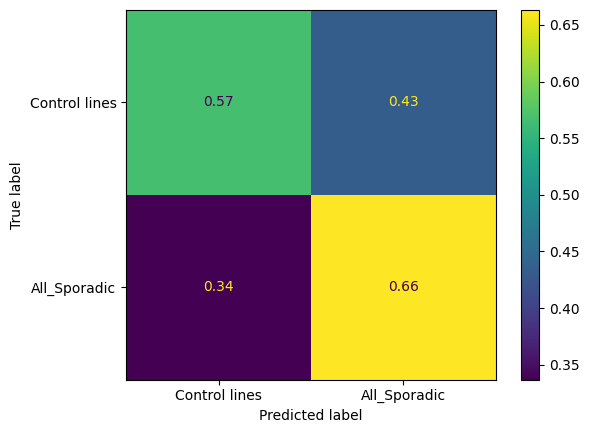

In [19]:
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds2, normalize = "true",display_labels=["Control lines","All_Sporadic"])

In [20]:
# Example: true labels and predicted probabilities
all_labels = [x.astype(int) for x in all_labels]
y_true = np.array(all_preds)
y_scores = np.array(all_labels)  # model output probabilities

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels,all_preds, pos_label=1)
roc_auc = auc(fpr, tpr)

# Create ROC curve with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr, 
    y=tpr,
    mode='lines',
    name=f'All_Sporadic (AUC = {roc_auc:.2f})',
    line=dict(color='blue', width=2)
))

# Add diagonal line for random guessing
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random',
    line=dict(color='red', dash='dash')
))

# Update layout
fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1]),
    template='plotly_white',
    width=700,
    height=500,
    legend=dict(title="ROC Curve", orientation="h", x=0.5, xanchor="center", y=-0.2)

)
#fig.show()
#fig.write_image("ROC_Curve.pdf")
fig.write_image(os.path.join(output_dir, "ROC_Curve.pdf"))


In [21]:
precision, recall, _ = precision_recall_curve(all_labels, all_preds)
ap_score = average_precision_score(all_labels, all_preds)

In [22]:
# Plot Precision-Recall curve
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=recall,
    y=precision,
    mode="lines",
    name=f"Precision-Recall curve (AP = {ap_score:.2f})",
    line=dict(color="blue")
))

# Add baseline (no-skill line at positive rate)
positive_rate = sum(all_labels) / len(all_labels)
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[positive_rate, positive_rate],
    mode="lines",
    name="No Skill",
    line=dict(color="red", dash="dash")
))

# Update layout
fig.update_layout(
    title="Precision-Recall Curve",
    xaxis=dict(title="Recall"),
    yaxis=dict(title="Precision"),
    template="plotly_white",
    legend=dict(title="PR curve", orientation="h", x=0.5, xanchor="center", y=-0.2)
)
#fig.show()
#fig.write_image("Precision_Recall.pdf")
fig.write_image(os.path.join(output_dir, "Precision_Recall.pdf"))


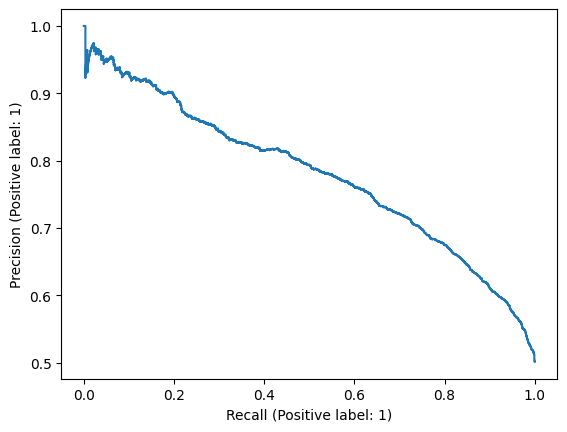

In [51]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall, pos_label=1)
disp.plot()

In [23]:
report = classification_report(all_labels, all_preds2, target_names=["All_Sporadic","Control"], output_dict=True)

In [24]:
import pandas as pd
pd.DataFrame(report).to_csv(os.path.join(output_dir,"classification_metrics.csv"))

In [31]:
df = pd.DataFrame(report)

In [32]:
df.drop(["macro avg","weighted avg"], axis=1,inplace=True)

In [33]:
df

,TDP-43,Control,accuracy
precision,0.714176,0.744410,0.728296
recall,0.761261,0.695332,0.728296
f1-score,0.736967,0.719035,0.728296
support,2442.000000,2442.000000,0.728296


In [34]:
#df = df.transpose()
df = df.round(3)

In [38]:
df = df.reset_index()

In [39]:
df.columns = ['Metric', 'TDP-43', 'Control', 'accuracy']

In [28]:
df.drop(["index","Class"],axis=1,inplace=True)

In [40]:
# Reset index to include row labels ("TDP-43", "Control", etc.)
#df.reset_index(inplace=True)
#df.rename(columns={'index': 'Class'}, inplace=True)

# Create Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='lightgrey',
                align='center'),
    cells=dict(values=[df[col] for col in df.columns],
               fill_color='white',
               align='center'))
])

# Update layout
fig.update_layout(title="Classification Report")

fig.write_image("classification_report.pdf")


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_handles = []

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def __call__(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = output.argmax(dim=0).item() #dim=1 for batch

        self.model.zero_grad()
        
        class_score =  output[class_idx]            #output[:, class_idx]
        
        class_score.backward(retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize
        return cam

    def clear_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

In [ ]:
target_layer = model.encoder.features[-2]  # Use the last conv block of ResNet

gradcam = GradCAM(model, target_layer)

In [309]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
    #                     std=[0.229, 0.224, 0.225]),
])

In [378]:
def load_image(img_path):
    image = tifffile.imread(img_path)

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    if image.shape[2] == 1:
        image = np.repeat(image, 3, axis=2)  # Grayscale to RGB

    image = image.astype(np.float32)
    image /= image.max()
    print(image.shape)
    #img_np = image.reshape((224,224,3))
    
    #print(img_np.shape)

    image = Image.fromarray((image * 255).astype(np.uint8))
    
    input_tensor = data_transforms(image).unsqueeze(0).to(device)
    return image, np.array(image.resize((224,224))), input_tensor
    
def load_image_run_gradcam(img_path, model):
    # 1. Load and preprocess the image
    img_resized, img_np, input_tensor = load_image(img_path)
    print(model(input_tensor))
    class_idx = model(input_tensor).argmin()
    print(class_idx)
    cam = gradcam(input_tensor)  # cam should be [H, W], values in [0, 1]
    # 3. Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # [H, W, 3], BGR
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0  # Convert to RGB + normalize
    alpha = 0.5

    # 4. Overlay heatmap onto image
    overlay = alpha * img_np + (1-alpha) * heatmap
    overlay = np.clip(overlay, 0, 1)
    return img_resized,overlay,heatmap
    
def load_image_run_saliency_map(img_path, model):
    # 1. Load and preprocess the image
    img_resized, img_np, input_tensor = load_image(img_path)
    input_tensor.requires_grad_()
    output = model(input_tensor)
    
    class_idx = output.argmax()
    # Backward pass for that class
    model.zero_grad()
    output[class_idx].backward()

    saliency = input_tensor.grad.data.abs().max(dim=1)[0]
    saliency = input_tensor.grad.data.abs()  # absolute value of gradients
    saliency, _ = torch.max(saliency, dim=1)  # Take max along channel dimension
    saliency = saliency.squeeze().cpu().numpy()  # [H, W]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    saliency = np.uint8(saliency * 255)
    saliency_colored = cv2.applyColorMap(saliency, cv2.COLORMAP_JET)
    saliency_colored = cv2.cvtColor(saliency_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.7

    # 4. Overlay heatmap onto image
    overlayed = alpha * img_np + (1-alpha) * saliency_colored
    overlayed = np.clip(overlayed, 0, 1)
    return img_resized,overlayed

def save_gradcam(img_path,save_path, cmap='jet'):
    img_resized,gradcam = load_image_run_gradcam(img_path, model)
    _, ablationcam  = load_img_apply_ablationcam(img_path, model)
    plt.figure(figsize=(18, 6))
    title1 = "Image"
    # First image
    plt.subplot(1, 3, 1)
    plt.imshow(img_resized, cmap='jet')
    plt.title(title1)
    plt.axis('off')
    title2 = "Grad-cam overlay"
    # Second image
    plt.subplot(1, 3, 2)
    plt.imshow(gradcam, cmap='jet')
    plt.title(title2)
    plt.axis('off')
    plt.tight_layout()
    # Third image
    title3 = "Ablation-cam overlay"
    plt.subplot(1, 3, 3)
    plt.imshow(ablationcam, cmap='jet')
    plt.title(title3)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save before plt.show()
    


In [379]:
img_paths =  os.listdir("/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/test/1/")

In [380]:
img_path = os.path.join("/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/test/1/", img_paths[1000])

In [381]:
img_path

'/gladstone/finkbeiner/steve/work/data/npsad_data/monika/Julia_TDP43/test/1/PID20230630_JAK-GSGT14_T1_0-1_C11_0_FITC_0_1_0_BGpbs_MN_139.tif'

In [382]:
image = tifffile.imread(img_path)

In [383]:
img_resized,img_np, input_tensor = load_image(img_path)

(115, 115, 3)


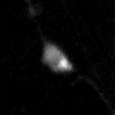

In [384]:
img_resized

In [385]:
img_resized,overlayed,heatmap = load_image_run_gradcam(img_path, model)

(115, 115, 3)
tensor([ 6.2782, -7.5500], device='cuda:0', grad_fn=<ViewBackward0>)
tensor(1, device='cuda:0')


/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/torch/nn/modules/module.py:1827: FutureWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



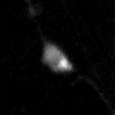

In [386]:
img_resized

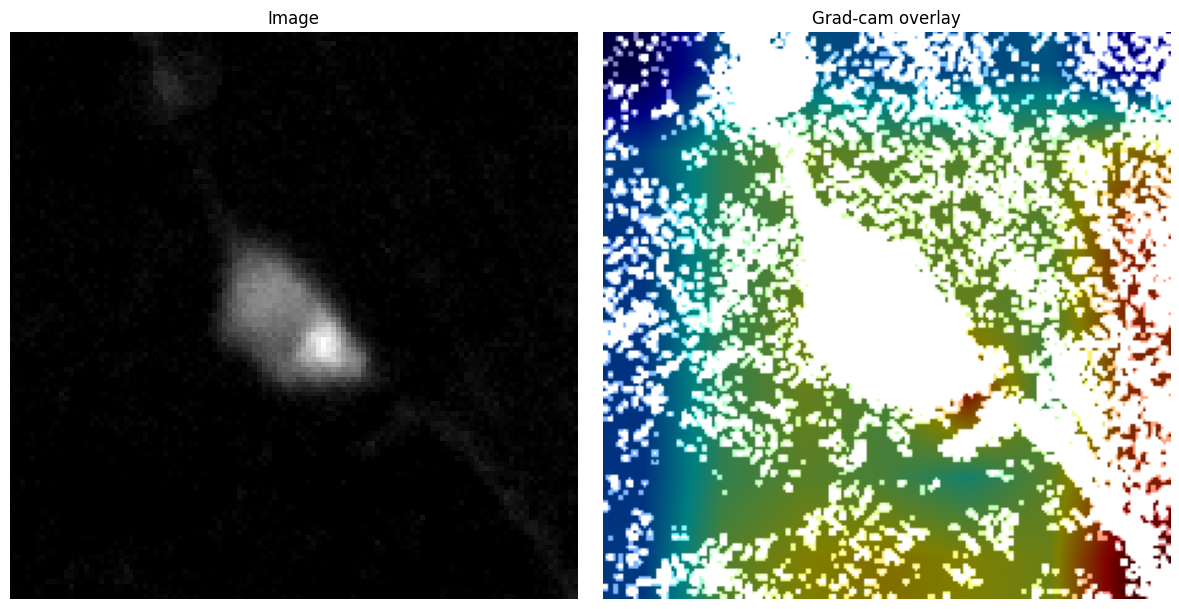

In [387]:
plt.figure(figsize=(12, 6))
title1 = "Image"
# First image
plt.subplot(1, 2, 1)
plt.imshow(img_resized, cmap='jet')
plt.title(title1)
plt.axis('off')
title2 = "Grad-cam overlay"
# Second image
plt.subplot(1, 2, 2)
plt.imshow(overlayed, cmap='jet')
plt.title(title2)
plt.axis('off')
plt.tight_layout()

In [388]:
img_resized,overlayed = load_image_run_saliency_map(img_path, model)

(115, 115, 3)


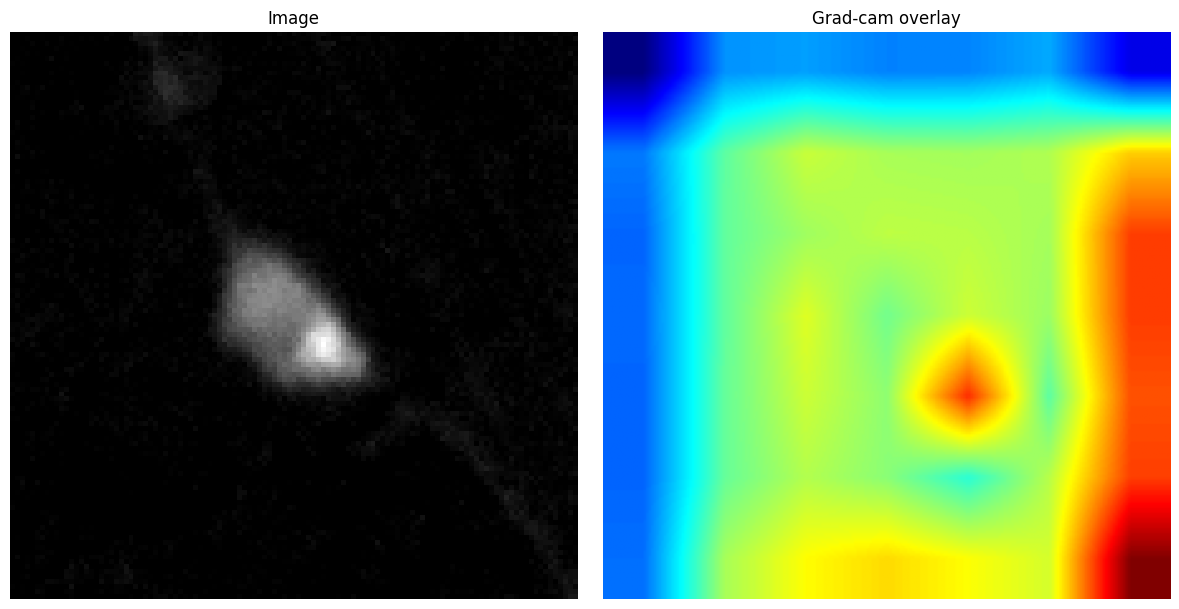

In [389]:
plt.figure(figsize=(12, 6))
title1 = "Image"
# First image
plt.subplot(1, 2, 1)
plt.imshow(img_resized, cmap='jet')
plt.title(title1)
plt.axis('off')
title2 = "Grad-cam overlay"
# Second image
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.title(title2)
plt.axis('off')
plt.tight_layout()